This notebook compares full_phase_interpolation with selected predictors with full_phase_interpolation with all predictors.

In [1]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Full phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 2, 1, 3])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250)) 

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1, 3])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit_pcc = RuleFitWrapper(mode='chain')

full_estimators = [lr_ind, lr_pcc, lr_chain, rf_ind, rf_pcc, rf_chain, rufit_pcc]
full_names = ['LR_ind', 'LR_pcc', 'LR_chain', 'RF_ind', 'RF_pcc', 'Rf_chain', 'Rufit_pcc']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result. (See below instructions)

```
import pickle
cur_save=open('./' + 'interpolation_30folder' + '.p', 'rb')
interpolation = pickle.load(cur_save)
```
After running these three-line code, you can ignore the following __interpolation__ code and re-run the rest.

Due to the individual prediction accuracy

In [4]:
# data.y = data.y[['other', 'sphere', 'vesicle', 'worm']]
# data.y.head()

In [5]:
X = data.x.filter(data.predictors)
X

,clogp_corona,mon_corona_mw,mon_corona_apol,mon_corona_mv,mon_corona_psa,dp_corona,corona_mw_total,corona_mv_total,clogp_core,mon_core_mw,...,dp_core,core_mw_total,core_mv_total,ratio_mass,ratio_vol,conc,ph,salt,charged,temp
0,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,181,26226.8457,215.354886,0.254724,0.244374,10.0,7.0,0.0,0,70
1,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,121,17532.8637,143.966526,0.338302,0.326043,10.0,7.0,0.0,0,70
2,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,161,23328.8517,191.558766,0.277583,0.266637,10.0,7.0,0.0,0,70
3,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,201,29124.8397,239.151006,0.235343,0.225543,10.0,7.0,0.0,0,70
4,0.09,160.07,23.529516,1.2437,66.76,56,8963.92,69.6472,1.10445,144.8997,...,261,37818.8217,310.539366,0.191607,0.183192,10.0,7.0,0.0,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,0.09,160.07,23.529516,1.2437,66.76,54,8643.78,67.1598,1.10000,144.0800,...,180,25934.4000,213.300000,0.249978,0.239463,10.0,7.0,0.0,0,70
588,0.09,160.07,23.529516,1.2437,66.76,54,8643.78,67.1598,1.10000,144.0800,...,220,31697.6000,260.700000,0.214266,0.204843,10.0,7.0,0.0,0,70
589,0.09,160.07,23.529516,1.2437,66.76,37,5922.59,46.0169,1.10000,144.0800,...,80,11526.4000,94.800000,0.339423,0.326785,10.0,7.0,0.0,0,70
590,0.09,160.07,23.529516,1.2437,66.76,54,8643.78,67.1598,1.10000,144.0800,...,140,20171.2000,165.900000,0.299975,0.288166,20.0,7.0,0.0,0,70


In [6]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold

X = data.x.filter(data.predictors) # only consider the predictors

interpolation = Experiment(full_estimators, 
                    full_names,
                    KFold(30, shuffle=True, random_state=STATE),
                    X, data.y.replace(-1.0, 0.0),
                    groups=data.comp_ids.array, 
                    evaluators=['accuracy', LogLikelihoodEvaluator(2, neg=True)],
                    verbose=True).run()

Running experiment with 30 repetitions
******************************


In [18]:
# import pickle
# # save models in directory, remove comment to use it.
# cur_save=open('./' + 'interpolation_30folder_selected' + '.p', 'wb')
# pickle.dump(interpolation, cur_save, -1)
# cur_save.close()

In [10]:
import pickle
cur_save=open('./' + 'interpolation_30folder_selected' + '.p', 'rb')
interpolation = pickle.load(cur_save)

In [27]:
df1 = interpolation.summary()
df1.index = [each +'_selected' for each in df1.index.tolist()]
df1 # selected predictors

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_chain_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RF_ind_selected,0.999825,0.000533,0.783421,0.070991,0.260965,0.004806,1.201244,0.810822
RF_pcc_selected,0.999185,0.001356,0.800789,0.066668,0.245952,0.004644,1.163131,0.806772
Rf_chain_selected,1.000000,0.000000,0.805614,0.067503,0.246824,0.004042,1.119475,0.721598
Rufit_pcc_selected,0.956489,0.004821,0.790702,0.084958,0.374151,0.008400,1.009409,0.412079


In [30]:
# cur_save=open('./' + 'interpolation_30folder' + '.p', 'rb')
# interpolation2 = pickle.load(cur_save)
df2 = interpolation2.summary()
df2.index = [each +'_all' for each in df2.index.tolist()]
df2 # selected predictors

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_ind_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RF_ind_all,0.999825,0.000533,0.788860,0.075846,0.256396,0.004974,1.140403,0.702724
RF_pcc_all,0.999243,0.001186,0.792105,0.069495,0.245991,0.003946,1.087693,0.697455
rufit_pcc_all,0.954217,0.005492,0.792018,0.093704,0.370660,0.011791,1.063783,0.534343


In [49]:
import pandas as pd

df = pd.concat([df1, df2])
df = df.sort_index()
df

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
LR_chain_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_ind_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_ind_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_all,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
LR_pcc_selected,0.382689,0.011744,0.378509,0.149020,2.908712,0.011742,2.929920,0.345263
RF_ind_all,0.999825,0.000533,0.788860,0.075846,0.256396,0.004974,1.140403,0.702724
RF_ind_selected,0.999825,0.000533,0.783421,0.070991,0.260965,0.004806,1.201244,0.810822
RF_pcc_all,0.999243,0.001186,0.792105,0.069495,0.245991,0.003946,1.087693,0.697455
RF_pcc_selected,0.999185,0.001356,0.800789,0.066668,0.245952,0.004644,1.163131,0.806772
Rf_chain_selected,1.000000,0.000000,0.805614,0.067503,0.246824,0.004042,1.119475,0.721598


## Get Baseline

* __Logloss__   
For a single sample with true label $y \in \{0,1\}$ and a probability estimate $p=P(y=1)$, the log loss is:
  
$$L = -(y\log(p) + (1-y)\log(1-p))$$.

* __Error Rate__
For a sample of $n$ observations, the probability of $k$ unique observation is $\{p_1, p_2, \dots, p_k\}$. The error rate is:

$$
E_{rr} = 1 - argmax \{p_i: p_i \in \{p_1, \dots, p_k\}\}
$$


In [50]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
# df = interpolation.summary()
df['mean_train_error'] = 1- df['mean_train_accuracy']
df['std_train_error'] = df['std_train_accuracy']
df['mean_test_error'] = 1- df['mean_test_accuracy']
df['std_test_error'] = df['std_test_accuracy']

In [51]:
# base line
uniq, cnt = np.unique(data.y.values, axis=0, return_counts=True) 
prob = cnt/sum(cnt)
info_logloss = sum(-1*prob * np.log2(prob))
print('Informed logloss: ', info_logloss)

uniprob = np.array([1/16 for _ in range(16)])
uninfo_logloss =  sum(-1*uniprob * np.log2(uniprob))
print('Uninformed logloss: ', uninfo_logloss)

Informed logloss:  2.5225679165070907
Uninformed logloss:  4.0


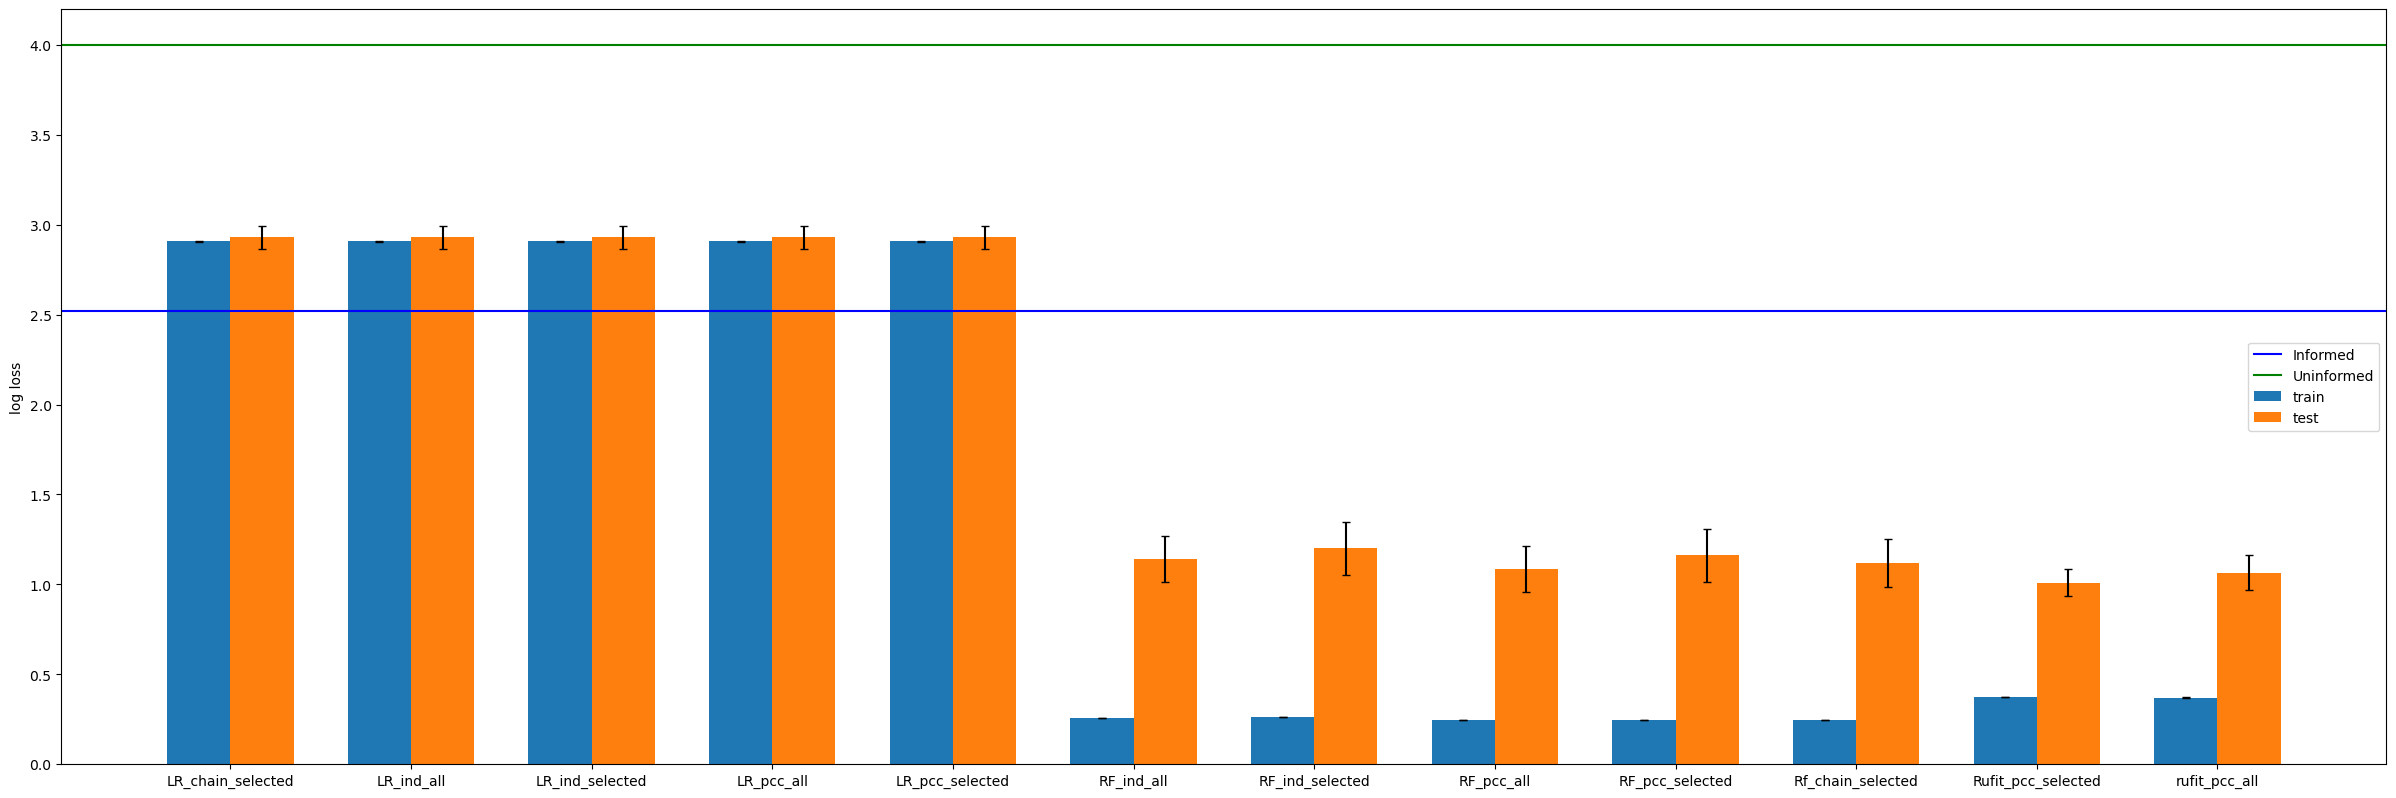

In [59]:
from matplotlib.pyplot import figure
figure(figsize=(30, 10), dpi=100)
plot_summary('log loss', summ=df, baseline=[info_logloss, uninfo_logloss], names=['Informed', 'Uninformed'])

In [54]:
# Error rate base line
uniq, cnts = np.unique(data.y.values, axis=0, return_counts=True)
prob = cnts/sum(cnts)
informed_error = 1- max(prob)
print('Informed Error: ', informed_error)

uninformed_error = 1-1/16
print('Uninformed Error: ', uninformed_error)

Informed Error:  0.5912162162162162
Uninformed Error:  0.9375


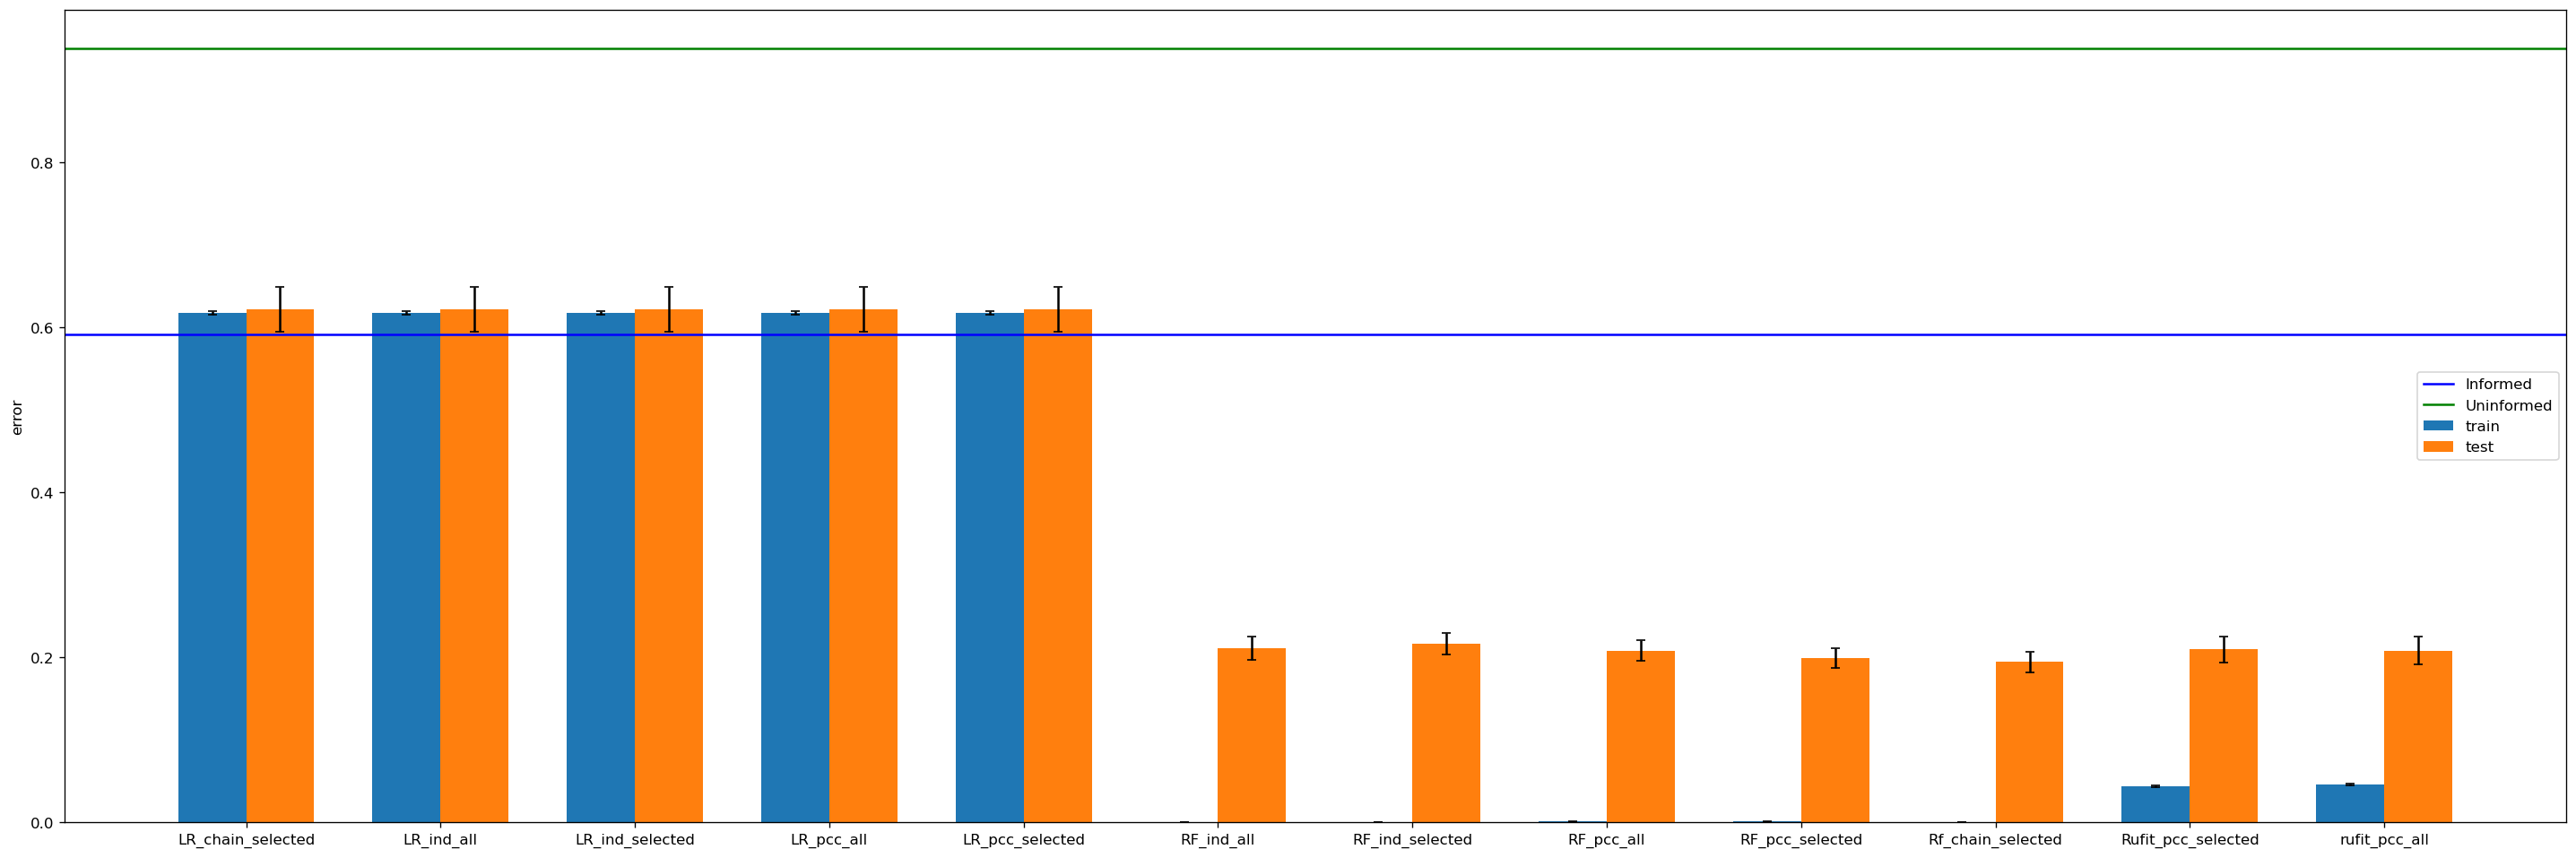

In [62]:
figure(figsize=(30, 10), dpi=120)
plot_summary('error', df, baseline=[informed_error, uninformed_error], names=['Informed', 'Uninformed']) # below plot is the error rate (1- accuracy)

## Get rules

After $30$ Folder CV, we have $30$ RuleFit estimators. We refit these estimators with whole dataset and select one having minimum log-loss and number of rules.

This is for full-phase, the chain rules first estimate __sphere__ and then treat __sphere__ as a predictor to estimate __worm__. The prediction order is __sphere, worm, vesicle__, and, __other__.

The output rules with coefficient of this notebook are in "Rules/Full_Phase/Interpolation/". The index of the csv names follow the prediction order as above.

In [13]:
def loss(y_test, y_pred):
    y_test = y_test.astype(np.float16)
    y_pred = y_pred.astype(np.float16)
    if len(y_test.shape) == 1:
        N = y_test.shape[0]
        loss = 0
        for i in range(N):
            loss -= ((y_test[i]*np.log(y_pred[i]))+((1.0-y_test[i])*np.log(1.0-y_pred[i])))
            loss = loss/N
    else:
        N,M = y_test.shape
        a=[]
        for m in range(M):
            loss=0
            for i in range(N):
                subloss = ((y_test[i,m]*np.log(y_pred[i,m]))+((1.0-y_test[i,m])*np.log(1.0-y_pred[i,m])))
                if np.isnan(subloss):
                    continue
                loss -= subloss
            loss = loss/N
            a.append(round(loss,8))
        loss = np.mean(a)
    return loss

In [16]:
# choose the best RuleFit
lst = []
for each in interpolation.fitted_['Rufit_pcc']:
    pred = each.predict_proba(X)
    res = log_loss(data.y.values, pred)
    lst.append((res, each))
lst.sort()
best_rf = lst[0][1]

In [17]:
dic = best_rf.get_rules(X, data.y)
indx = -1
for key, values in dic.items():
    indx += 1
    values = values.sort_values(by=['importance'], ascending=False)
    name = 'Rules/Full_Phase/Interpolation/'+ str(indx) + "_" + key + '.csv'
    values.to_csv(name, index=False)